<a href="https://colab.research.google.com/github/Marlrero/AI_PrimaryEducation/blob/main/airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Keras RNN으로 여행자 수 예측

#### 1. import package & set hyperparameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import MinMaxScaler # 최대-최소 정규화
from keras.layers import Dense, LSTM, InputLayer # LSTM(Long-Short Term Memory)
from keras.models import Sequential

In [2]:
# hyperparameters
MY_PAST = 12
MY_SHAPE = (MY_PAST, 1)
MY_HIDDEN = 300

MY_SPLIT = 0.8
MY_EPOCH = 300
MY_BATCH = 64

#### 2. read dataset

In [3]:
# header=None으로 해야 맨 위에 header를 데이터로 인식함
# usecols=[1]: 1번째 열만 사용한다는 의미
df = pd.read_csv('/content/drive/MyDrive/dataset/airline.csv', header=None, usecols=[1])
df.head(15)

,1
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


In [4]:
df.describe()

,1
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


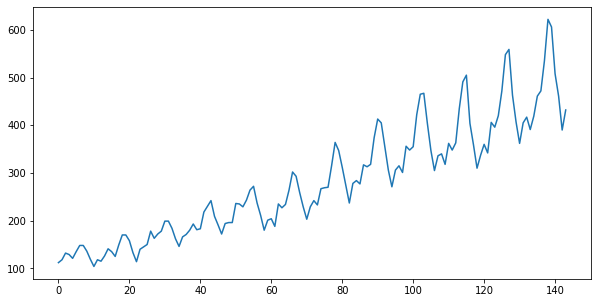

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df)

#### 3. data preprocessing

In [6]:
# Normalization
scaler = MinMaxScaler()
raw_DB = scaler.fit_transform(df) # pandas dataframe -> numpy array
print(type(df), type(raw_DB))
print(raw_DB.flatten()) # 1차원 배열로 펼침

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734


* MinMaxScaler는 숫자범위를 0 ~ 1까지로 만듦
* StandardScaler는 숫자범위가 아니고, 평균을 0으로 만들고 표준편차를 1로 만들기만 하고 숫자범위가 지정되어 있지 않음

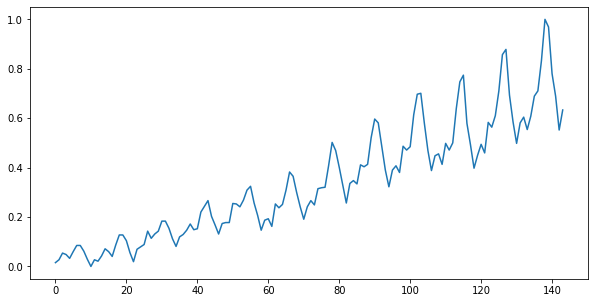

In [7]:
plt.figure(figsize=(10,5))
plt.plot(raw_DB)

* 정규화를 한다고 패턴(모양)이 바뀌지 않고, y축 범위가 바뀜(즉, 값의 범위를 0 ~ 1로 하는 것 뿐임)

In [8]:
# 데이터 분할
data = []

# 0 ~ 전체 데이터 길이 - MY_PAST - 1까지
for i in range(len(raw_DB) - MY_PAST):
  data.append(raw_DB[i:i + MY_PAST + 1])

print('한 묶음의 크기:', len(data[0]))
print('총 데이터 묶음 개수:', len(data))
print('첫번째 묶음:\n', data[0])

한 묶음의 크기: 13
총 데이터 묶음 개수: 132
첫번째 묶음:
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]]


* 12(12달=1년) + 1 = 13묶음
  * 1년치를 보고 그 다음 1월을 예측한다. (RNN)
* range(len(raw_DB) - MY_PAST)
  * 예: raw_DB가 12개라면, MY_PAST를 3으로 하면
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]에서 
        |<------------------------->|
             여기까지 반복해야 (3 + 1(다음예측))을 가능
        
        [0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], ...
        [8, 9, 10, 11] 까지

  * 0 ~ 12, 1 ~ 13, ..., 131 ~ 143 (모두 132개)

In [9]:
# data를 numpy로 전환한 후
print(type(data)) 
data = np.array(data)
print(type(data))

# 묶음 데이터를 섞고
np.random.shuffle(data) 
  # 데이터를 묶었기 때문에, 시계열 데이터 순서가 망가지지 않음
  # 위에서 묶음 안에서 시계열은 그대로 유지되기 때문

# 입력과 출력 분할
print("분할 전 데이터 형상:", data.shape) # (132*13) -> (132*13*1->한 값이 하나의 차원이 됨)
X_data = data[:, 0:MY_PAST] # 모든 행에 대해 0 ~ MY_PAST - 1까지 뽑기
Y_data = data[:, -1] # 모든 행에 대해 마지막 열 뽑기

<class 'list'>
<class 'numpy.ndarray'>
분할 전 데이터 형상: (132, 13, 1)


In [10]:
print("분할 후 데이터 형상:", X_data.shape, Y_data.shape)

split = int(data.shape[0] * MY_SPLIT)
print("{} * {} = {}".format(int(data.shape[0]), MY_SPLIT, split))
X_train = X_data[:split] # 0 ~ 105
X_test = X_data[split:]  # 105 ~ 132 (132 - 105 = 27)
Y_train = Y_data[:split] # 0 ~ 105
Y_test = Y_data[split:]  # 105 ~ 132 (132 - 105 = 27)

print("훈련 데이터 형상:", X_train.shape)
print("훈련 타깃 형상:", Y_train.shape)
print("검증 데이터 형상:", X_test.shape)
print("검증 타깃 형상:", Y_test.shape)

분할 후 데이터 형상: (132, 12, 1) (132, 1)
132 * 0.8 = 105
훈련 데이터 형상: (105, 12, 1)
훈련 타깃 형상: (105, 1)
검증 데이터 형상: (27, 12, 1)
검증 타깃 형상: (27, 1)


In [11]:
# 이렇게 해도 됨
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=1.0 - MY_SPLIT)
# or train_size=MY_SPLIT으로 해도 됨
print("훈련 데이터 형상:", X_train.shape)
print("훈련 타깃 형상:", Y_train.shape)
print("검증 데이터 형상:", X_test.shape)
print("검증 타깃 형상:", Y_test.shape)

훈련 데이터 형상: (105, 12, 1)
훈련 타깃 형상: (105, 1)
검증 데이터 형상: (27, 12, 1)
검증 타깃 형상: (27, 1)


#### 4. model creating

In [12]:
model = Sequential()

model.add(InputLayer(input_shape=MY_SHAPE)) # 12*1
model.add(LSTM(units=MY_HIDDEN))
model.add(Dense(units=1, activation="sigmoid"))
# 파라미터 개수 = 300 + 1(편향) = 301
# softmax = 숫자 여러 개를 확률로 만들어줌 (classification)
# sigmoid = 숫자 1개를 0 ~ 1 사이로 정규화 (regression)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


#### 5. Learning

In [13]:
# mape(mean absolute percentage error)
#  100 * mean(abs((y_true - y_pred) / y_true), axis=-1)
#  regression -> loss -> mae, rmse(mse)
#  classification -> loss -> cross-entropy
model.compile(optimizer='rmsprop', loss='mape', metrics=['acc'])

In [14]:
begin = time()
# 132개 밖에 안되서 batch_size 사용 안함
model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, verbose=2)
end = time()
print("Learning time: {:.2f}sec".format(end - begin))

Epoch 1/300
4/4 - 8s - loss: 116.9880 - acc: 0.0000e+00
Epoch 2/300
4/4 - 0s - loss: 99.7285 - acc: 0.0000e+00
Epoch 3/300
4/4 - 0s - loss: 99.3075 - acc: 0.0000e+00
Epoch 4/300
4/4 - 0s - loss: 93.1375 - acc: 0.0000e+00
Epoch 5/300
4/4 - 0s - loss: 71.0134 - acc: 0.0000e+00
Epoch 6/300
4/4 - 0s - loss: 65.6499 - acc: 0.0000e+00
Epoch 7/300
4/4 - 0s - loss: 67.3990 - acc: 0.0000e+00
Epoch 8/300
4/4 - 0s - loss: 64.7020 - acc: 0.0000e+00
Epoch 9/300
4/4 - 0s - loss: 43.3117 - acc: 0.0095
Epoch 10/300
4/4 - 0s - loss: 58.2978 - acc: 0.0000e+00
Epoch 11/300
4/4 - 0s - loss: 44.4497 - acc: 0.0000e+00
Epoch 12/300
4/4 - 0s - loss: 41.5496 - acc: 0.0000e+00
Epoch 13/300
4/4 - 0s - loss: 41.5059 - acc: 0.0000e+00
Epoch 14/300
4/4 - 0s - loss: 33.6827 - acc: 0.0095
Epoch 15/300
4/4 - 0s - loss: 48.5192 - acc: 0.0000e+00
Epoch 16/300
4/4 - 0s - loss: 39.9287 - acc: 0.0095
Epoch 17/300
4/4 - 0s - loss: 35.6374 - acc: 0.0095
Epoch 18/300
4/4 - 0s - loss: 42.4348 - acc: 0.0000e+00
Epoch 19/300
4/4

#### 6. Model evaluating & Prediction

In [15]:
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print('Total Loss:', score[0])
print('Accuracy:', score[1]) # Regression에서는 정확도 의미없음.

1/1 [==============================] - 0s 343ms/step - loss: 18.8089 - acc: 0.0000e+00
Total Loss: 18.808889389038086
Accuracy: 0.0


In [16]:
pred = model.predict(x=X_test)
pred = scaler.inverse_transform(pred) # 정규화한 것을 역변환

print(pred.shape)
# squeeze 함수는 배열에서 1차원 축을 제거하는 것임
tmp = np.squeeze(pred).astype(int)
print(tmp.shape)
print("Predicated value:", tmp)

(27, 1)
(27,)
Predicated value: [224 261 199 310 356 183 143 406 296 435 203 245 158 257 396 294 370 266
 338 207 175 144 192 193 155 423 333]


In [17]:
# 정답 변환
Y_test = scaler.inverse_transform(Y_test)
tmp = np.squeeze(Y_test).astype(int)
print("Answer:", tmp)

Answer: [267 306 229 342 355 181 125 461 356 491 242 274 166 317 407 364 396 271
 310 233 178 162 236 201 163 390 406]


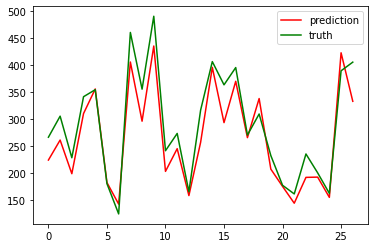

In [18]:
# LSTM 정확도는 손실함수 값(mape)으로도 보고, 예측값과 dataset의 정답을 시각화해야 함

plt.plot(pred, "r") # red
plt.plot(Y_test, 'g') # green
plt.legend(['prediction', 'truth'])
plt.show()